<a href="https://colab.research.google.com/github/nathaliavasconcelos-create/MVP_SMSSpamAnalysis.ipynb/blob/main/MVP_SMSSpamAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP - Análise de potenciais SPAMs em SMS

Aluna: Nathalia Vasconcelos Cardoso Rodrigues

# 1. Introdução
O presente MVP tem como objetivo analisar o dataset referente a mensagens de texto, em inglês *Short Message Service* (SMSs), contendo potenciais conteúdos de SPAM. O dataset foi obtido a partir do link: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset. Além disso, é possível encontrá-lo disponível no repositório UC Irvine.

Para resolver o problema de classificação proposto, serão adotados alguns algoritmos de classificação, a saber: SVM, Random Forest, KNN, Logistic Regression, Árvore de Decisão e Naive Bayes. Após a aplicação de cada algoritmo, os resultados obtidos serão comparados, de modo a observar os melhores desempenhos.

Cabe sinalizar a relevância de realizar um trabalho envolvendo tal tipo de dataset. Segundo a revista Forbes (2021), em uma matéria intitulada "The Past, Present And Future Of Messaging", no mundo inteiro são trocadas 23 bilhões de SMS por dia. Este valor expressivo demonstra a vitalidade e importância deste tipo de serviço. Por outro lado, segundo uma notícia do jornal Vox, usando dados do relatório feito pela companhia Validity, 96% dos usuários já se sentiram incomodados pelo recebimento de SPAM através de mensagens de texto. Além disso, 70% dos entrevistados expressaram receio pela segurança de seus dados online. Dados como os apresentados mostram como o serviço de SMS segue em constante atividade no mundo inteiro, porém vem sendo impactado por spams que prejudicam a interação do usuário com o serviço.

A seguir, apresenta-se o código gerado para trabalhar o problema de classificação de mensagens de texto em "spam" ou "ham" (não-spam).



1.1. Imports necessários



In [5]:
#Imports necessários
#import da biblioteca Panda
import pandas as pd
#import do módulo strings
import string
#para converter uma coleção de dados brutos em uma matriz de recursos do TF-IDF.
from sklearn.feature_extraction.text import TfidfVectorizer
#para realizar a validação cruzada
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
#para importar algoritmo KNN
from sklearn.neighbors import KNeighborsClassifier
#para importar algoritmo Naive Bayes
from sklearn.naive_bayes import GaussianNB
#para importar o algoritmo Árvore de Classificação
from sklearn.tree import DecisionTreeClassifier
#para importar o algoritmo SVM
from sklearn.svm import SVC
 #para importar o algoritmo de Regressão Logística
from sklearn.linear_model import LogisticRegression
#para importar o algoritmo Random Forest
from sklearn.ensemble import RandomForestClassifier
#
from sklearn.preprocessing import LabelEncoder
#para organizar os dados em tabelas
from tabulate import tabulate
#para elaboração de gráficos estatísticos
import seaborn as sns
import matplotlib.pyplot as plt
# Para realizar o undersampling
from imblearn.under_sampling import RandomUnderSampler

# 2. O dataset
Desenvolvido por Tiago Almeida e José Hidalgo, o dataset é composto por 5 colunas, saber: as classes "spam" e "ham", o texto de cada SMS e duas colunas sem nome. Cabe destacar que o dataset não contém valores nulos.

A composição deste dataset foi feita com base em fontes disponíveis de maneira gratuita e online. Segundo informações da página do dataset no Repositório da UC Irvine:

Uma coleção de 425 mensagens de spam extraída manualmente do site Grumbletext; um fórum britânico no qual usuários reclamam sobre as SMSs contendo SPAM;
Um subconjunto de 3.375 mensagens SMS escolhidas aleatoriamente do NUS SMS Corpus (NSC);
Uma lista de 450 mensagens SMS 'ham' coletadas da tese de doutorado de Caroline Tag;
o SMS Spam Corpus v.0.1 Big. Possui 1.002 SMS "ham" e 322 SMS "spam".
Por fim, o dataset está desbalanceado, na medida em que, os dados considerados "ham" representam 87% do total, ao passo que os dados de "spam" perfazem 13% do total. Essa informação aparece na forma de gráfico ao final desta secção.





2.1. Import do dataset e investigação da sua estrutura



In [6]:
#Url a importar
url_dados = 'https://github.com/nathaliavasconcelos-create/MVP_SMSSpamAnalysis.ipynb/blob/main/spam_dataset.csv'

# Carregar o dataset e realizar o enconding, dado que o dataset possuía caracteres que não poderiam ser lidos
df = pd.read_csv(url_dados.replace('/blob/', '/raw/'), encoding='latin-1')

# Verificar as primeiras linhas do dataset
print(df.head())

# Verificar as distribuições dos valores de "spam"/"ham", lembrando que a coluna em que este
#dado é apresentado no dataset tem como nome v1.
print(df['v1'].value_counts())

     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  
v1
ham     4825
spam     747
Name: count, dtype: int64


In [7]:
# Mesmo já tendo visto as primeiras linhas do dataset, verifica-se,
# para confirmar, as colunas existentes no dataset
print(df.columns)

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')


In [8]:
# Selecionar apenas as colunas relevantes para este trabalho, no caso, v1 e v2
df = df[['v1', 'v2']]
print (df.columns)

Index(['v1', 'v2'], dtype='object')


In [9]:
#Renomear as colunas, tornando os seus nomes mais intuitivos
df.rename(columns={'v1': 'categoria', 'v2': 'mensagem'}, inplace=True)
print (df)

     categoria                                           mensagem
0          ham  Go until jurong point, crazy.. Available only ...
1          ham                      Ok lar... Joking wif u oni...
2         spam  Free entry in 2 a wkly comp to win FA Cup fina...
3          ham  U dun say so early hor... U c already then say...
4          ham  Nah I don't think he goes to usf, he lives aro...
...        ...                                                ...
5567      spam  This is the 2nd time we have tried 2 contact u...
5568       ham              Will Ì_ b going to esplanade fr home?
5569       ham  Pity, * was in mood for that. So...any other s...
5570       ham  The guy did some bitching but I acted like i'd...
5571       ham                         Rofl. Its true to its name

[5572 rows x 2 columns]


In [10]:
# Verificar valores nulos
# Ainda que a informação sobre ausência de valores nulos seja oferecida pelos
# próprios autores do dataset, vale a verificação
print(df.isnull().sum())

categoria    0
mensagem     0
dtype: int64


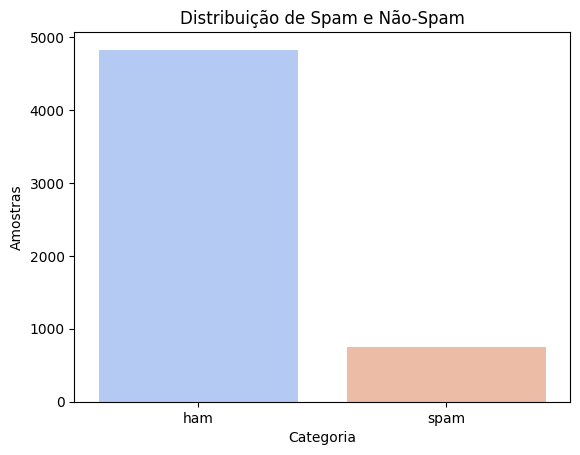

In [11]:
# Visualizar a distribuição dos valores de Spam x Não-Spam ('Ham') no dataset
sns.countplot(x='categoria', data=df, hue= 'categoria', palette ='coolwarm', order=df['categoria'].value_counts().index)
plt.xlabel('Categoria')
plt.ylabel('Amostras')
plt.title('Distribuição de Spam e Não-Spam')
plt.show()

# 3. Pré-processamento dos dataset

Nesta secção, serão realizadas as técnicas de normalização do texto. Além disso, serão convertidos os valores de spam e ham para valores numéricos.


In [12]:
# Pré-processamento: limpar os dados de texto e aplicar o TF-IDF
X = df['mensagem']  # As mensagens de texto
y = df['categoria']    # A variável de destino (spam ou não spam)

# Codificar os rótulos (spam -> 1, não spam -> 0)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Converter as mensagens em uma matriz de características numéricas com TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)  # 5000 palavras mais importantes
X_tfidf = vectorizer.fit_transform(X)

# 4. Os algoritmos adotados

Como mencionado na Introdução deste trabalho, os algoritmos adotados serão SVM, Random Forest, KNN, Logistic Regression, Árvore de Decisão e Naive Bayes.

Destaca-se que para o caso do algoritmo KNN foram feitas mudanças no hiperparâmetro "K-neighbors" ("k-vizinhos"), atribuindo-lhe os valores 3, 5, 7, 9 e 11, de modo a observar possíveis alterações nas métricas obtidas. O treinamento deste modelo será feito à parte, evitando que o código fique confuso.

Dos algoritmos anteriormente mencionados, coloca-se como hipótese de que o Random Forest será aquele com melhor desempenho. Esta hipótese advém do fato de que tal algoritmo é capaz de lidar inclusive com classes desbalanceadas

Por fim, é importante ressaltar que nesta secção serão feitas as validações cruzadas e o undersampling. Este último será realizado para mitigar possíveis efeitos que o desbalanceamento do dataset possa gerar.

4.1. Algoritmos Random Forest, SVM, Decision Tree, Logistic Regression e Decision Tree

In [18]:
# Converter as mensagens em uma matriz de características numéricas com TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)  # 5000 palavras mais importantes
X_tfidf = vectorizer.fit_transform(X)

# Aplicar undersampling para balancear as classes
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_tfidf, y_encoded)

Random Forest - Acurácia Média: 0.9821
SVM - Acurácia Média: 0.9803
Decision Tree - Acurácia Média: 0.9693
Logistic Regression - Acurácia Média: 0.9620
Naive Bayes - Acurácia Média: 0.8853


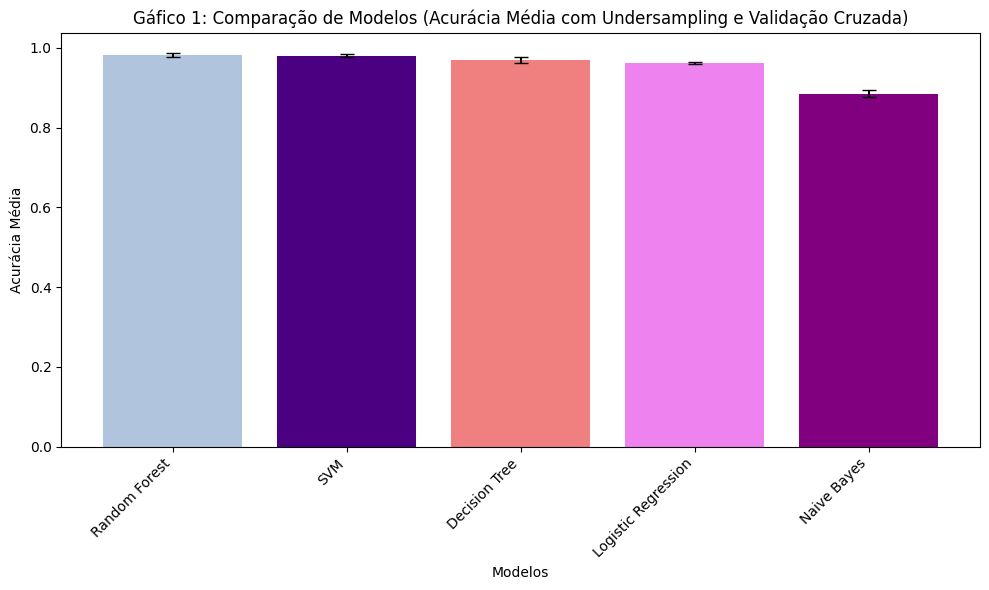

In [19]:
# Definir o número de folds para validação cruzada
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Definir os classificadores
models = {
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),  # max_iter ajustado para garantir convergência
    'Naive Bayes': GaussianNB()
}

# Listas para armazenar os resultados
model_names = []
mean_accuracies = []
std_devs = []

# Aplicar validação cruzada para cada modelo
for name, model in models.items():
    # Convert to dense array if model is Naive Bayes
    if name == 'Naive Bayes':
        X_dense = X_tfidf.toarray()  # Convert sparse matrix to dense array for Naive Bayes
        cv_scores = cross_val_score(model, X_dense, y_encoded, cv=kfold, scoring='accuracy')
    else:
        cv_scores = cross_val_score(model, X_tfidf, y_encoded, cv=kfold, scoring='accuracy')

    model_names.append(name)
    mean_accuracies.append(cv_scores.mean())
    std_devs.append(cv_scores.std())

# Exibir os valores numéricos das acurácias médias e desvios padrão
for i in range(len(model_names)):
    print(f"{model_names[i]} - Acurácia Média: {mean_accuracies[i]:.4f}")


# Criando o gráfico comparativo
plt.figure(figsize=(10, 6))
plt.bar(model_names, mean_accuracies, yerr=std_devs, capsize=5, color=['lightsteelblue', 'indigo', 'lightcoral', 'violet', 'purple'])
plt.title('Gáfico 1: Comparação de Modelos (Acurácia Média com Undersampling e Validação Cruzada)')
plt.xlabel('Modelos')
plt.ylabel('Acurácia Média')
plt.xticks(rotation=45, ha='right')  # Para não sobrepor as labels no gráfico
plt.tight_layout()
plt.show()

4.4. O algoritmo KNN

KNN com 3 vizinhos - Acurácia Média: 0.7263
KNN com 5 vizinhos - Acurácia Média: 0.6955
KNN com 7 vizinhos - Acurácia Média: 0.6519
KNN com 9 vizinhos - Acurácia Média: 0.6487
KNN com 11 vizinhos - Acurácia Média: 0.6534


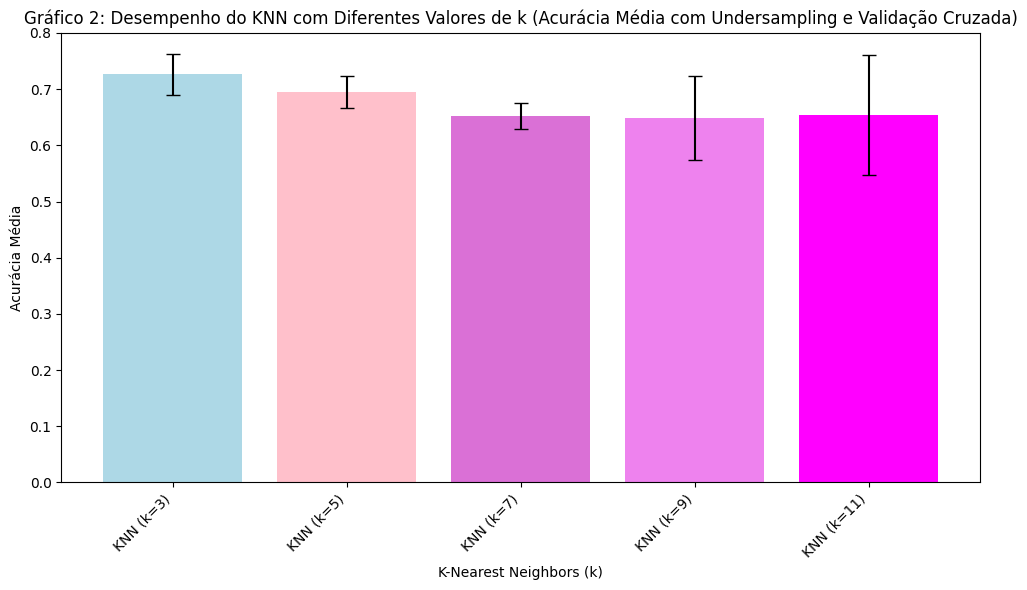

In [25]:
# Testar diferentes valores de n_neighbors para o KNN
k_values = [3, 5, 7, 9, 11]
mean_accuracies = []
std_devs = []
knn_model_names = [] # Creating a new list to store KNN model names


# Aplicar validação cruzada para cada valor de n_neighbors
for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(knn_model, X_resampled, y_resampled, cv=kfold, scoring='accuracy')

    mean_accuracies.append(cv_scores.mean())
    std_devs.append(cv_scores.std())
    knn_model_names.append(f"KNN (k={k})") # Appending KNN model names


# Exibir resultados
for i, k in enumerate(k_values):
    print(f"KNN com {k} vizinhos - Acurácia Média: {mean_accuracies[i]:.4f}")

# Plotando as acurácias para diferentes valores de n_neighbors
plt.figure(figsize=(10, 6))
plt.bar(knn_model_names, mean_accuracies, yerr=std_devs, capsize=5, color=['lightblue','pink','orchid','violet', 'fuchsia']) # Using the correct model names for KNN
plt.title('Gráfico 2: Desempenho do KNN com Diferentes Valores de k (Acurácia Média com Undersampling e Validação Cruzada)')
plt.xlabel('K-Nearest Neighbors (k)')
plt.ylabel('Acurácia Média')
plt.xticks(rotation=45, ha='right')  # Para não sobrepor as labels no gráfico
plt.tight_layout()
plt.show()

In [28]:
# Organizando as acurácias obtidas para cada modelo em uma tabela comparativa
lista = [
    ["Modelo", "Acurácia"],
    ["KNN (k=9)", 0.6487],
    ["KNN (k=7)", 0.6519],
    ["KNN (k=11)", 0.6534],
    ["KNN (K=5)", 0.6955],
    ["KNN (k=3)", 0.7263],
    ["Naive Bayes", 0.8853],
    ["Logistic Regression", 0.9620],
    ["Decision Tree", 0.9693],
    ["SVM", 0.9803],
    ["Random Forest", 0.9821],
]
print ('Tabela 1: Relação Modelo x Acurácias - Valores em ordem crescente')
print(tabulate(lista, headers= 'firstrow', tablefmt='fancy_grid'))

Tabela 1: Relação Modelo x Acurácias - Valores em ordem crescente
╒═════════════════════╤════════════╕
│ Modelo              │   Acurácia │
╞═════════════════════╪════════════╡
│ KNN (k=9)           │     0.6487 │
├─────────────────────┼────────────┤
│ KNN (k=7)           │     0.6519 │
├─────────────────────┼────────────┤
│ KNN (k=11)          │     0.6534 │
├─────────────────────┼────────────┤
│ KNN (K=5)           │     0.6955 │
├─────────────────────┼────────────┤
│ KNN (k=3)           │     0.7263 │
├─────────────────────┼────────────┤
│ Naive Bayes         │     0.8853 │
├─────────────────────┼────────────┤
│ Logistic Regression │     0.962  │
├─────────────────────┼────────────┤
│ Decision Tree       │     0.9693 │
├─────────────────────┼────────────┤
│ SVM                 │     0.9803 │
├─────────────────────┼────────────┤
│ Random Forest       │     0.9821 │
╘═════════════════════╧════════════╛


# 5. Conclusões

Tendo em vista a tabela 1 apresentada na secção anterior, os melhores resultados de acurácia foram obtidos pelos algoritmos Random Forest e SVM, com valores de 0,9821 e 0,9803, respectivamente.Este resultado confirma nossa hipótese inicial. No entanto, destaca-se que não foram previstos resultados tão satisfatórios para o SVM e mesmo para os algoritmos Decision Tree e Logistic Regression.


# 6. Próximos passos

Como etapas futuras deste projeto, poderia ser interessante coletar mais amostras de SMSs SPAM, de modo a tornar o dataset mais balanceado. Além disso, poderia ser elaborado um dataset com amostras em português brasileiro. Por fim, o tipo de análise aqui realizada poderia ser expandido para outros serviços, como, por exemplo, e-mail.

# 7. Referências bibliográficas

GIACOMINI, Andrea. 2021. *The past, present and the future of messaging*.In: Forbes.
Disponível em: https://www.forbes.com/councils/forbestechcouncil/2021/01/06/the-past-present-and-future-of-messaging/#:~:text=Messaging%20Of%20Today,interactions%20continue%20to%20be%20scarce. (data do último acesso: 12/12/2024)

STEWART, Emily. 2023. *You’re not imagining it, brands are texting you way more*. In: VOX. Disponível em: https://www.vox.com/money/23786037/text-message-marketing-sms-companies-robotexts-spam-email. (data do último acesso: 12/12/2024)

